# Training of -layer NN with basic features
In this notebook, a vanilla 2-layer neural network is trained on all basic-engineered features.

- ReLU after the first liner layer
- Sigmoid after the second linear layer
- Batch Size: 64
- Hidden dim: 16
- Learning Rate: 0.1
- Num. of epochs: 100

We will save the models in "models/vanillann" of our Google Drive.


## 0. Imports and Constants
- Change the path in "cw_dir" to your local Google Drive sync location
- Specify the dataset version in the CONSTANTS part

In [17]:
# AUTORELOAD
%load_ext autoreload
%autoreload 2

# IMPORTS
import numpy as np
import torch

# TASK-SPECIFIC IMPORTS
from src.vanilla_dataset import VanillaDataset, DataLoader
from src.vanilla_nn import VanillaNN
from src.evaluate import evaluate_model
from src.train import training_loop, plot_losses

# PATH CONSTANTS
dataset_version = "v2"
cw_dir = "/home/jockl/Insync/check.worthiness@gmail.com/Google Drive"
data_dir = f"{cw_dir}/data/CT23_1A_checkworthy_multimodal_english_{dataset_version}"
features_dir = f"{data_dir}/features"
labels_dir = f"{data_dir}/labels"
models_dir = f"{cw_dir}/models/vanillann"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Dictionary Keys
In this notebook, we will use dictionaries to reference corresponding data splits, feature engineering methods, labels, dataloaders etc. The following keys are used all the way:

In [18]:
# CONSTANT DICT KEYS
SPLITS = ["train", "dev"]
FE_METHODS = ["concat", "concat_cos", "sum", "sum_cos", "mean", "mean_cos", "hadamard", "hadamard_cos"]

Note that the test split is not used in this notebook!

## 2. Load Training and Dev Labels
First, we load the labels from the pickle files. We will later use them to set up our Dataloaders.

In [19]:
# Load training and dev labels from pickle file as np.array
split_to_labels = {split: np.load(f"{labels_dir}/{split}_labels_{dataset_version}.pickle", allow_pickle=True) for split in SPLITS}

Our label arrays have the following dimensions:

In [20]:
for split in SPLITS:
    print(f"{split} labels: {split_to_labels[split].shape} {split_to_labels[split][:10]}")

train labels: (2356,) [1 1 0 1 0 0 0 0 0 0]
dev labels: (271,) [0 0 0 1 1 0 0 0 1 1]


## 3. Load Engineered Features
Now, all engineered feature matrices for the train and dev split are loaded from their respective pickle files. We store them in a dictionary that maps split to feature method feature matrix.


In [21]:
# Load all engineered feature matrices for train and dev split
split_to_method_to_matrix = {split: {fe_method: np.load(f"{features_dir}/{fe_method}/{fe_method}_{split}_{dataset_version}.pickle", allow_pickle=True) for fe_method in FE_METHODS} for split in SPLITS}

Those are the shapes of our feature matrices:

In [22]:
for split in SPLITS:
    for fe_method in FE_METHODS:
        print(f"{split}, {fe_method}: {split_to_method_to_matrix[split][fe_method].shape}")

train, concat: (2356, 1536)
train, concat_cos: (2356, 1537)
train, sum: (2356, 768)
train, sum_cos: (2356, 769)
train, mean: (2356, 768)
train, mean_cos: (2356, 769)
train, hadamard: (2356, 768)
train, hadamard_cos: (2356, 769)
dev, concat: (271, 1536)
dev, concat_cos: (271, 1537)
dev, sum: (271, 768)
dev, sum_cos: (271, 769)
dev, mean: (271, 768)
dev, mean_cos: (271, 769)
dev, hadamard: (271, 768)
dev, hadamard_cos: (271, 769)


# 3. Set up the PyTorch Datasets and Dataloaders
We set up a PyTorch Dataset and a Dataloader for every split and feature matrix loaded in the previous section. First, we define a batch size that every Dataloader uses. This batch size is constant throughout this notebook.

In [29]:
# Define batch size for all Dataloaders
batch_size = 64

Now, we instantiate our Datasets and Dataloaders.

In [30]:
# Instantiate VanillaDatasets
split_to_method_to_dataset = {split: {fe_method: VanillaDataset(split_to_method_to_matrix[split][fe_method], split_to_labels[split]) for fe_method in FE_METHODS} for split in SPLITS}

# Instantiate Dataloaders
split_to_method_to_dataloader = {split: {fe_method: DataLoader(split_to_method_to_dataset[split][fe_method], batch_size=batch_size) for fe_method in FE_METHODS} for split in SPLITS}

Let's have a look at the first batch from the dataloader of the train split, using the plainly concatenated features:

In [31]:
# Get example dataset/dataloader from the dictionaries
example_train_loader = split_to_method_to_dataloader["train"]["concat"]
example_train_set = split_to_method_to_dataset["train"]["concat"]

# Print info
print(f"No. of examples in the training set: {len(example_train_set[0][0])}")
for batch_no, batch in enumerate(example_train_loader):
    print(f"Batch No: {batch_no}\nfeatures in batch: {batch[0].shape}\nlabels in batch: {batch[1].shape}")
    break

No. of examples in the training set: 1536
Batch No: 0
features in batch: torch.Size([64, 1536])
labels in batch: torch.Size([64])


# 4. Example Network
This section briefly shows what a network would look like for the example of the previous section.

In [32]:
# Network parameters
example_input_dim = len(example_train_set[0][0])
example_hidden_dim = 16
example_output_dim = 1

# Instantiate the network
example_network = VanillaNN(example_input_dim, example_hidden_dim, example_output_dim)
print(example_network)

VanillaNN(
  (linear_one): Linear(in_features=1536, out_features=16, bias=True)
  (linear_two): Linear(in_features=16, out_features=1, bias=True)
)


After the first linear layer, the ReLU non-linearity is applied. The output of the second linear layer is squashed by the Sigmoid function. For details, see the implementation of the forward pass in vanilla_nn.py

# 5. Train and Save Models
In this section, we train a network for all feature engineering methods. The following parameters are used:

In [33]:
# Training params
lr = 0.1
loss_fn = torch.nn.BCELoss()
num_epochs = 100
hidden_dim = 16
output_dim = 1

We now train the models, save them and plot the step-wise losses. Uncomment this cell only if you want to train and overwrite the already saved models!

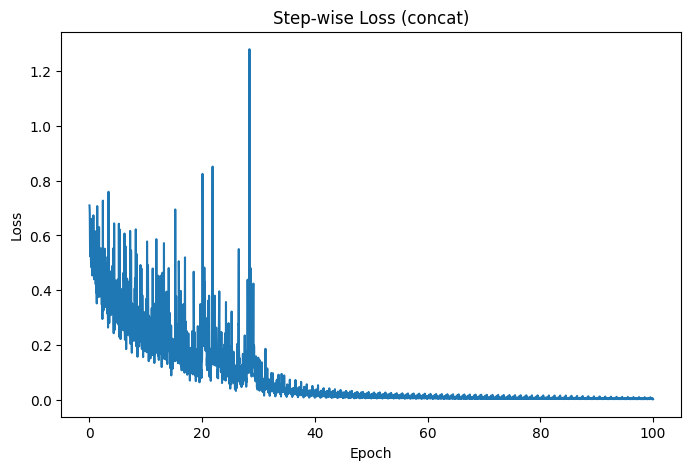

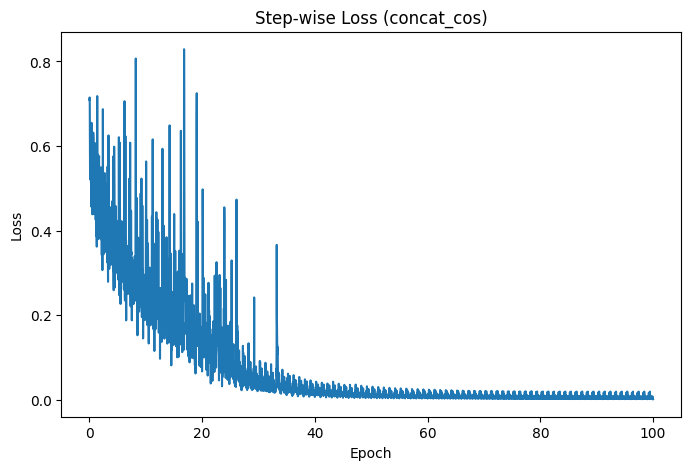

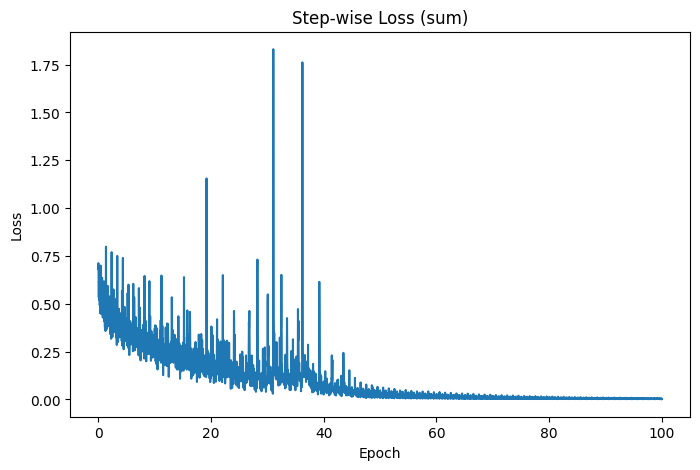

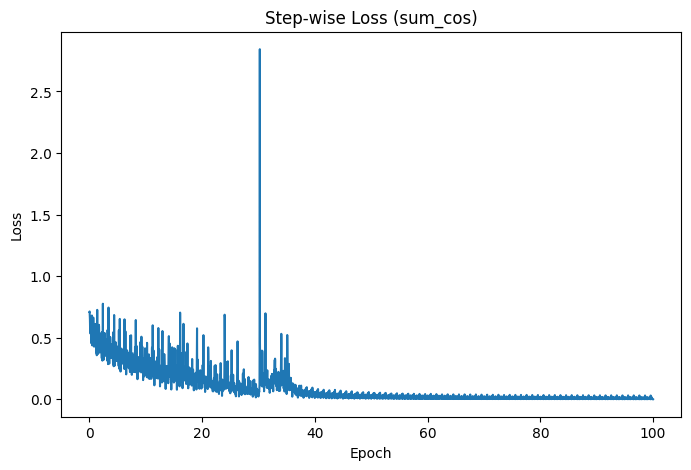

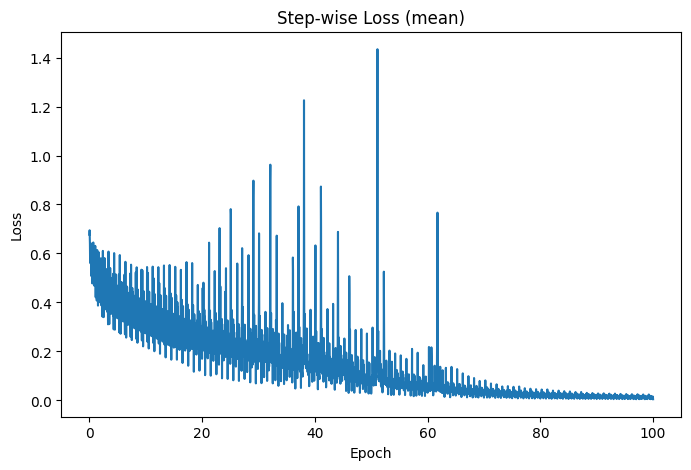

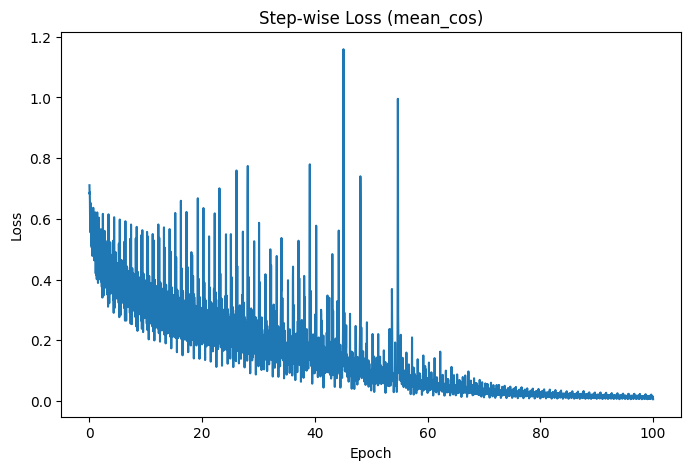

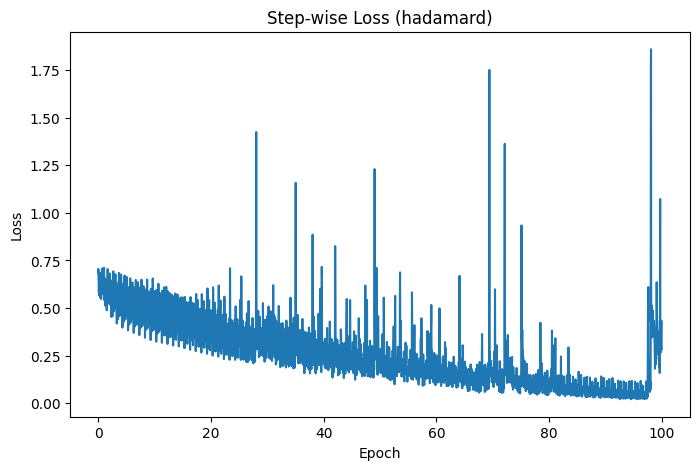

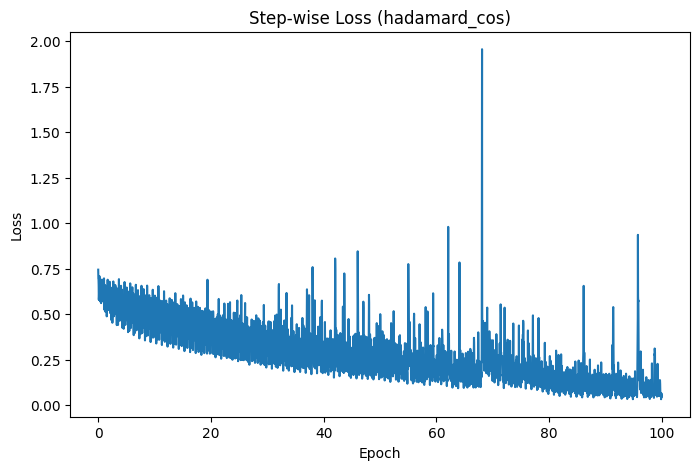

In [34]:
"""
# Training model for every feature engineering method
for fe_method in FE_METHODS:
   
    # Get dataset and dataloader
    train_set = split_to_method_to_dataset["train"][fe_method]
    train_dataloader = split_to_method_to_dataloader["train"][fe_method]

    # Instantiate the model
    input_dim = len(train_set[0][0])
    model = VanillaNN(input_dim, hidden_dim, output_dim)

    # Instantiate the optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    # Train the model
    losses = training_loop(train_dataloader, optimizer, model, loss_fn, num_epochs)

    # Plot losses
    plot_losses(num_epochs, losses, fe_method)

    # Save the model
    model_path = f"{models_dir}/{fe_method}_{dataset_version}.pt"
    torch.save(model.state_dict(), model_path)
"""

# 7. Load Models and Evaluate
In this section, we load our trained models and compute basic metrics on the dev data.

In [40]:
# Evaluate model for every feature engineering method
for fe_method in FE_METHODS:
   
    # Get dev dataset and dev dataloader
    dev_set = split_to_method_to_dataset["dev"][fe_method]
    dev_dataloader = split_to_method_to_dataloader["dev"][fe_method]

    # Instantiate the model
    input_dim = len(dev_set[0][0])
    model = VanillaNN(input_dim, hidden_dim, output_dim)

    # Load the model 
    path = f"{models_dir}/{fe_method}_{dataset_version}.pt"
    model.load_state_dict(torch.load(path))
    model.eval()

    # Compute basic metrics
    print(f"\n{fe_method}\n")
    print(evaluate_model(model, dev_dataloader))
    


concat

              precision    recall  f1-score   support

         0.0       0.88      0.80      0.84       184
         1.0       0.65      0.76      0.70        87

    accuracy                           0.79       271
   macro avg       0.76      0.78      0.77       271
weighted avg       0.80      0.79      0.79       271


concat_cos

              precision    recall  f1-score   support

         0.0       0.89      0.80      0.84       184
         1.0       0.65      0.78      0.71        87

    accuracy                           0.79       271
   macro avg       0.77      0.79      0.77       271
weighted avg       0.81      0.79      0.80       271


sum

              precision    recall  f1-score   support

         0.0       0.90      0.81      0.85       184
         1.0       0.67      0.82      0.74        87

    accuracy                           0.81       271
   macro avg       0.79      0.81      0.79       271
weighted avg       0.83      0.81      0.82   